# Visualization and correlation between variables

Now we will do different visualizations to see how related our columns are.

We load our necessary libraries:

In [ ]:
!pip install ipywidgets
!pip install umap-learn

In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
import umap

If you are compiling this notebook in Colab, please go to https://drive.google.com/drive/folders/1GcQyj0DZYH_U-Pv-ZJUNcSVcNcSZTl1k?usp=sharing, upload each of the files to Colab (on the left side of this cell) and adjust the comments (#)



We load the file that contains the processed columns, inputs and no rows with the 5 important variables empty.

In [91]:
path_save_parquet_1 = os.path.join('..','data', 'processed', 'Ensanut-data-processed.parquet') 
#path_save_parquet_1 = os.path.join('/content/Ensanut-data-processed.parquet')
df_1 = pd.read_parquet(path_save_parquet_1)
df_1['Sexo'] = df_1['Sexo'].astype('category')
df_1['C_Entidad'] = df_1['C_Entidad'].astype('category')
# Convertir la columna 'Fecha' al tipo datetime y extraer el año
df_1['Fecha'] = pd.to_datetime(df_1['Fecha'], errors='coerce')
df_1['Año'] = df_1['Fecha'].dt.year


## Number of people surveyed.

Let's first see how many surveys were done in each edition, as well as the distribution of men with women.

We will also use the "Fecha_ii" column because it has no gaps and is imputed correctly.

### "Real" number of surveys carried out

(remember that there are missing values ​​here)

In [92]:
df_1['Año'] = df_1['Año'].replace({1999: 2000, 2001: 2000, 2008:2006})

# Filtrar hombres (Sexo = 1) y mujeres (Sexo = 2)
hombres_por_anio = df_1[df_1['Sexo'] == 1].groupby('Año')['Sexo'].count()
mujeres_por_anio = df_1[df_1['Sexo'] == 2].groupby('Año')['Sexo'].count()

# Combinar ambos resultados en un solo DataFrame
totales_por_anio = pd.DataFrame({
    'Hombres': hombres_por_anio,
    'Mujeres': mujeres_por_anio
}).fillna(0).astype(int)  # Rellenar valores faltantes con 0
totales_por_anio['Total'] = totales_por_anio['Hombres'] + totales_por_anio['Mujeres']
# Resultados
totales_por_anio

Hombres  Mujeres  Total
Año                            
2000.0    22264    25268  47532
2006.0    32269    38029  70298
2012.0    30274    36889  67163
2018.0    28478    32517  60995
2020.0     4562     6234  10796
2021.0     7264    10290  17554
2022.0     6518     8942  15460
2023.0     3645     5051   8696

### Imputed number of surveys carried out.

This table shows us the number of men, women and the total number of interviews done using the imputed column.

In [93]:
df_1['Fecha_ii'] = pd.to_datetime(df_1['Fecha_ii'], errors='coerce')
df_1['Año_ii'] = df_1['Fecha_ii'].dt.year
df_1['Año_ii'] = df_1['Año_ii'].replace({1999: 2000, 2001: 2000, 2008:2006})

# Filtrar hombres (Sexo = 1) y mujeres (Sexo = 2)
hombres_por_anio = df_1[df_1['Sexo'] == 1].groupby('Año_ii')['Sexo'].count()
mujeres_por_anio = df_1[df_1['Sexo'] == 2].groupby('Año_ii')['Sexo'].count()

# Combinar ambos resultados en un solo DataFrame
totales_por_anio = pd.DataFrame({
    'Hombres': hombres_por_anio,
    'Mujeres': mujeres_por_anio
}).fillna(0).astype(int)  # Rellenar valores faltantes con 0
totales_por_anio['Total'] = totales_por_anio['Hombres'] + totales_por_anio['Mujeres']
# Resultados
totales_por_anio

Hombres  Mujeres  Total
Año_ii                         
2000      22267    25271  47538
2006      32269    38029  70298
2012      30274    36889  67163
2018      28478    32517  60995
2020       4562     6234  10796
2021       7264    10290  17554
2022       6518     8942  15460
2023       3645     5051   8696

Let's do a visualization:

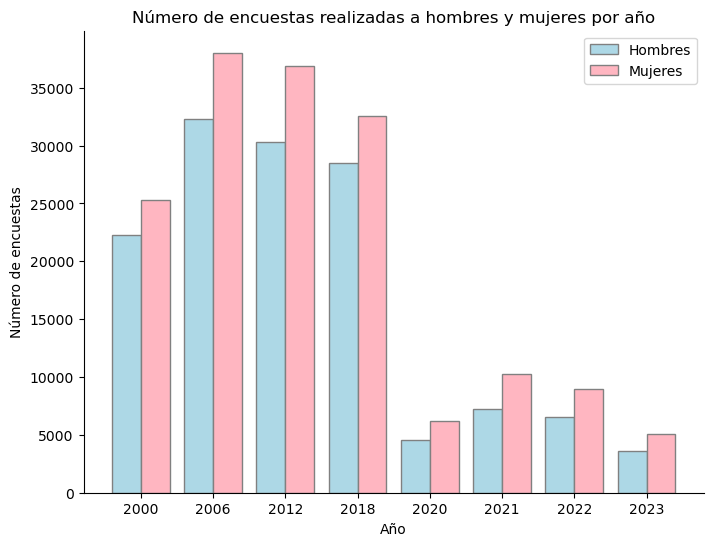

In [94]:
totales_por_anio['Total'] = totales_por_anio['Hombres'] + totales_por_anio['Mujeres']
totales_por_anio.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Posiciones de las barras
bar_width = 0.4
r1 = range(len(totales_por_anio))
r2 = [x + bar_width for x in r1]

# Dibujar las barras
ax.bar(r1, totales_por_anio['Hombres'], color='#ADD8E6', width=bar_width, edgecolor='grey', label='Hombres')  # Color azul claro
ax.bar(r2, totales_por_anio['Mujeres'], color='#FFB6C1', width=bar_width, edgecolor='grey', label='Mujeres')  # Color rosa claro

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Año')
ax.set_ylabel('Número de encuestas')
ax.set_xticks([r + bar_width / 2 for r in range(len(totales_por_anio))])
ax.set_xticklabels(totales_por_anio['Año_ii'].tolist())  # Años como etiquetas
ax.set_title('Número de encuestas realizadas a hombres y mujeres por año')
ax.legend()

# Despinar (quitar bordes derecho y superior)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


## Correlations.

We'll start with a visualization of the correlations between our columns.

First, let's declare some variables:

In [95]:
# Definir las columnas de interés para el análisis
numerical_cols = ['Año','Edad']
categorical_cols = ['Atentar_contras_si', 'Depresion', 'Tristeza', 'Frecuencia emborrachar','Cuantos cigarrillos (numero)']

# Visualización de correlación entre salud mental y hábitos (matriz de correlación)
# Convertir categorías a factores numéricos para correlación
df_corr = df_1[categorical_cols + numerical_cols].apply(lambda x: pd.factorize(x)[0] if x.dtype.name == 'category' else x)

### Pearson correlation:

Our values ​​with the Pearson correlation are the following:

In [96]:
df_corr.corr(method = 'pearson')

Atentar_contras_si  Depresion  Tristeza  \
Atentar_contras_si                      1.000000   0.285118  0.029533   
Depresion                               0.285118   1.000000  0.677589   
Tristeza                                0.029533   0.677589  1.000000   
Frecuencia emborrachar                 -0.117700   0.061036  0.004536   
Cuantos cigarrillos (numero)           -0.080573  -0.056570 -0.008694   
Año                                     0.636490   0.592662  0.394715   
Edad                                   -0.233587   0.250781  0.349784   

                              Frecuencia emborrachar  \
Atentar_contras_si                         -0.117700   
Depresion                                   0.061036   
Tristeza                                    0.004536   
Frecuencia emborrachar                      1.000000   
Cuantos cigarrillos (numero)                0.054203   
Año                                         0.049289   
Edad                                        0.191511   

                              Cuantos cigarrillos (numero)       Año      Edad  
Atentar_contras_si                               -0.080573  0.636490 -0.233587  
Depresion                                        -0.056570  0.592662  0.250781  
Tristeza                                         -0.008694  0.394715  0.349784  
Frecuencia emborrachar                            0.054203  0.049289  0.191511  
Cuantos cigarrillos (numero)                      1.000000 -0.089850  0.182301  
Año                                              -0.089850  1.000000  0.148764  
Edad                                              0.182301  0.148764  1.000000

To visualize it, the following figure is implemented:

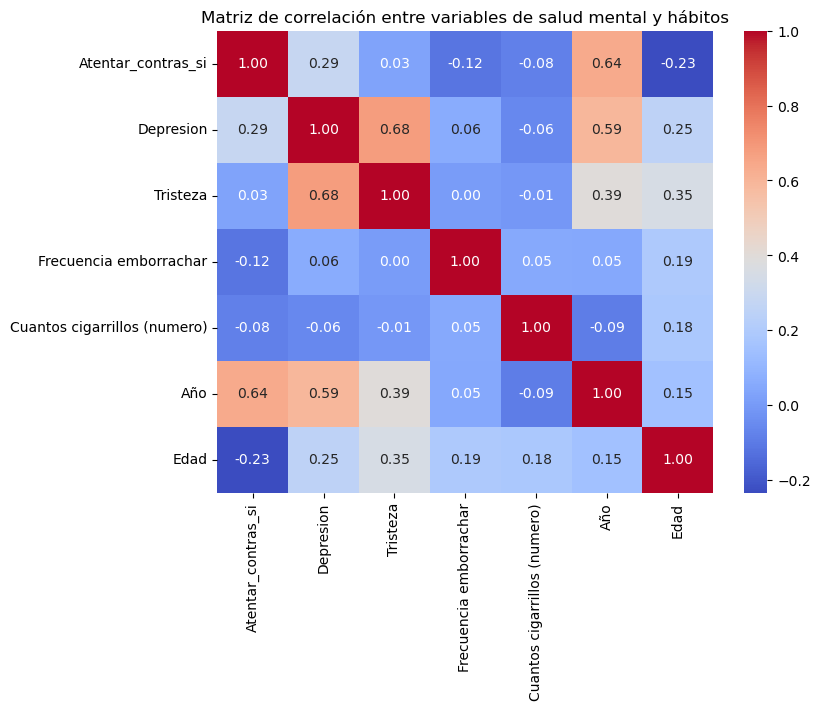

In [97]:
correlation_matrix = df_corr.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables de salud mental y hábitos")
plt.show()


Since the Pearson correlation does not handle categorical variables well, as it assumes a continuous scale and a linear relationship, we will do the analysis with two other types of correlation.

### Kendall correlation.

Our values ​​are:

In [98]:
df_corr.corr(method = 'kendall')

Atentar_contras_si  Depresion  Tristeza  \
Atentar_contras_si                      1.000000   0.327954  0.010278   
Depresion                               0.327954   1.000000  0.600745   
Tristeza                                0.010278   0.600745  1.000000   
Frecuencia emborrachar                 -0.117565   0.085590  0.009236   
Cuantos cigarrillos (numero)           -0.113114  -0.087987  0.000716   
Año                                     0.560727   0.595078  0.337929   
Edad                                   -0.225466   0.223161  0.326691   

                              Frecuencia emborrachar  \
Atentar_contras_si                         -0.117565   
Depresion                                   0.085590   
Tristeza                                    0.009236   
Frecuencia emborrachar                      1.000000   
Cuantos cigarrillos (numero)                0.077952   
Año                                         0.080198   
Edad                                        0.186719   

                              Cuantos cigarrillos (numero)       Año      Edad  
Atentar_contras_si                               -0.113114  0.560727 -0.225466  
Depresion                                        -0.087987  0.595078  0.223161  
Tristeza                                          0.000716  0.337929  0.326691  
Frecuencia emborrachar                            0.077952  0.080198  0.186719  
Cuantos cigarrillos (numero)                      1.000000 -0.110253  0.158468  
Año                                              -0.110253  1.000000  0.114482  
Edad                                              0.158468  0.114482  1.000000

For this correlation it can be visualized as follows:

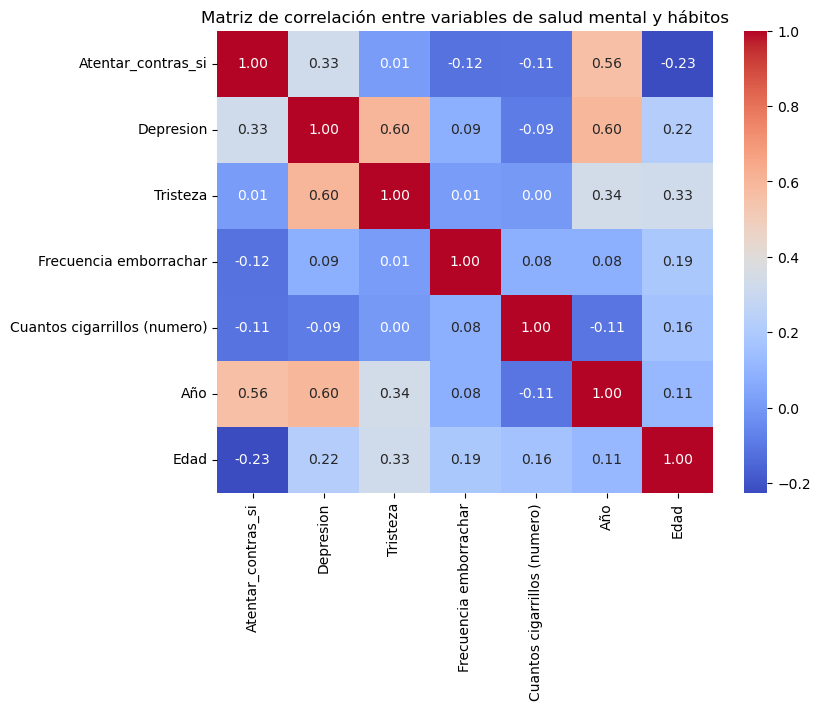

In [99]:
correlation_matrix = df_corr.corr(method='kendall')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables de salud mental y hábitos")
plt.show()

### Spearman correlation

With the Spearman correlation we obtain the following values:

In [100]:
df_corr.corr(method = 'spearman')

Atentar_contras_si  Depresion  Tristeza  \
Atentar_contras_si                      1.000000   0.347291  0.011123   
Depresion                               0.347291   1.000000  0.634571   
Tristeza                                0.011123   0.634571  1.000000   
Frecuencia emborrachar                 -0.132627   0.102037  0.011380   
Cuantos cigarrillos (numero)           -0.131869  -0.106157  0.000878   
Año                                     0.636821   0.711843  0.417040   
Edad                                   -0.276541   0.283369  0.423035   

                              Frecuencia emborrachar  \
Atentar_contras_si                         -0.132627   
Depresion                                   0.102037   
Tristeza                                    0.011380   
Frecuencia emborrachar                      1.000000   
Cuantos cigarrillos (numero)                0.099439   
Año                                         0.094705   
Edad                                        0.252399   

                              Cuantos cigarrillos (numero)       Año      Edad  
Atentar_contras_si                               -0.131869  0.636821 -0.276541  
Depresion                                        -0.106157  0.711843  0.283369  
Tristeza                                          0.000878  0.417040  0.423035  
Frecuencia emborrachar                            0.099439  0.094705  0.252399  
Cuantos cigarrillos (numero)                      1.000000 -0.140942  0.220765  
Año                                              -0.140942  1.000000  0.156210  
Edad                                              0.220765  0.156210  1.000000

And its visualization is the following:

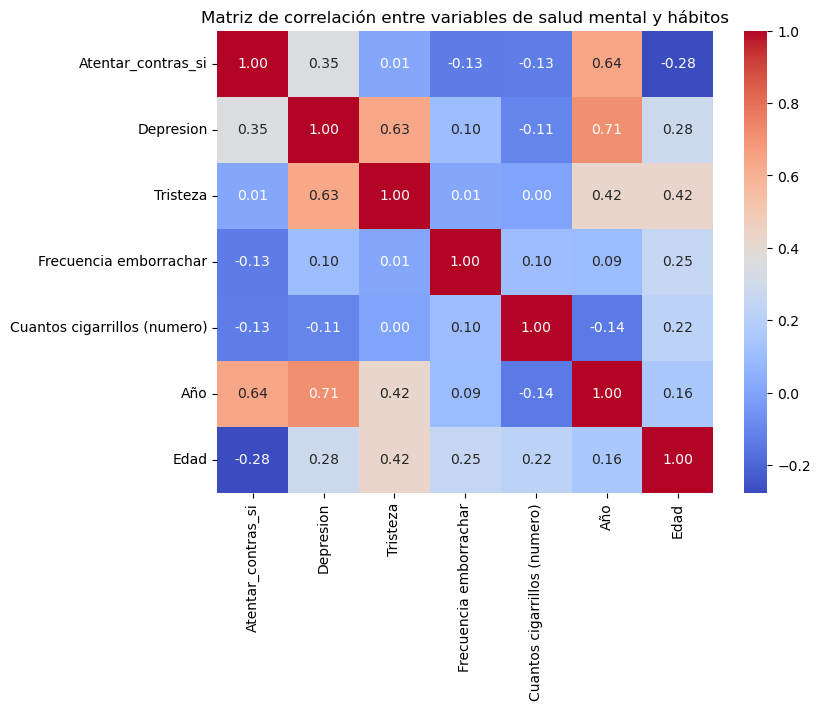

In [101]:
correlation_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables de salud mental y hábitos")
plt.show()

In this case we will stay with the results of the Spearman correlation.

### Possible interpretation:

1. Atentar_contras_si and Year (0.637): There is a strong positive correlation, suggesting that as the years progress, there is a significant increase in the tendency to report intentions to self-harm.

2. Depression and Sadness (0.635): The high positive correlation indicates a strong relationship between depressive symptoms and feeling sad. It is expected that these two variables are closely linked given that sadness is a common symptom of depression.

3. Self-harm intentions and Depression (0.347): A moderate positive correlation suggests that those who report self-harm intentions tend to have higher levels of depression.

4. Age and Sadness (0.423): This moderate positive correlation indicates that sadness may increase with age.

5. Frequency of drunkenness and Age (0.252): The positive correlation, although lower, suggests that the frequency of drunkenness may increase slightly with age.

6. How many cigarettes (number) and Age (0.221): A moderate positive correlation indicates that the number of cigarettes smoked tends to increase with age.

7. Year and Depression (0.712): Strong positive correlation, suggesting that depressive symptoms have increased significantly over the years.


### Assumptions (not necessarily completely correct):
Temporal Relationships: Strong correlations between the year and variables such as Atentar_contras_yes and Depression suggest worrying trends over time. It could be useful to investigate social or economic factors that could be influencing these increases. In this case it is advisable to verify if the number of surveys answered each year does not influence.

Mental Health: The strong relationship between Depression and Sadness confirms the interconnection of these emotional aspects. This could indicate the need for comprehensive approaches in mental health treatment.

Behavior and Age: Correlations between age and behaviors such as smoking and drunkenness suggest that these behaviors may change with age. Public health policies could specifically target different age groups.

# Relationship between variables per display.

Below is a series of boxplots to see how our categorical variables are distributed with the numerical ones.

As the first boxplot we have how the number of cigarettes consumed per week is distributed in the "Tristeza" variable:


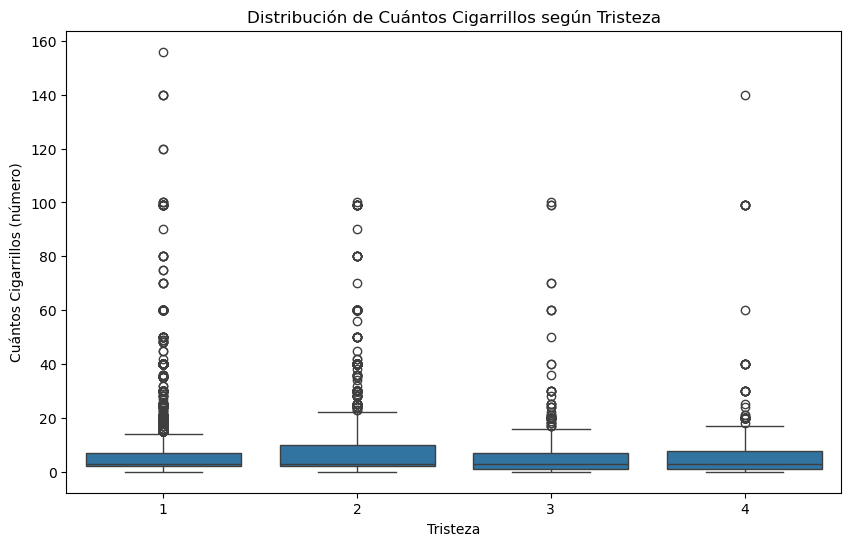

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot para ver la distribución de 'Cuantos cigarrillos (numero)' según 'Tristeza'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tristeza', y='Cuantos cigarrillos (numero)', data=df_1)
plt.title('Distribución de Cuántos Cigarrillos según Tristeza')
plt.xlabel('Tristeza')
plt.ylabel('Cuántos Cigarrillos (número)')
plt.show()


The same is obtained for how the number of cigarettes consumed per week is distributed in the "Depresion" variable:


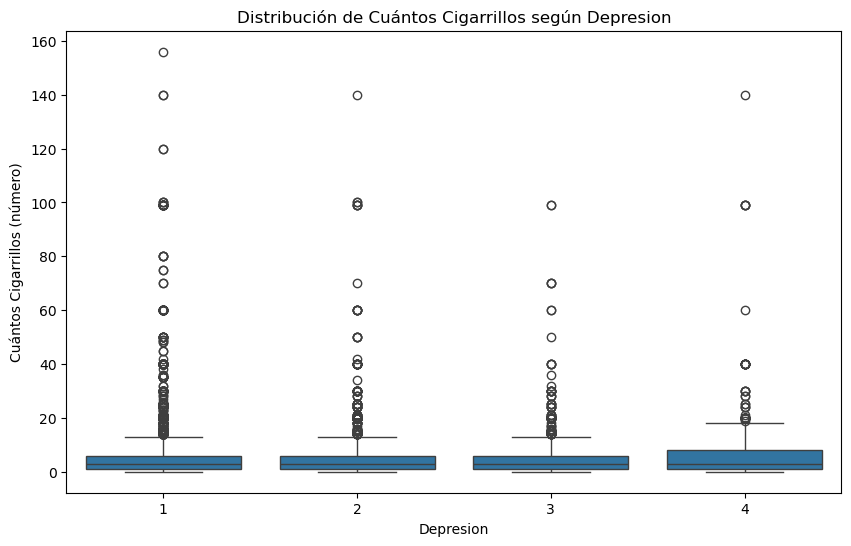

In [103]:
# Box plot para ver la distribución de 'Cuantos cigarrillos (numero)' según 'Depresion'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Depresion', y='Cuantos cigarrillos (numero)', data=df_1)
plt.title('Distribución de Cuántos Cigarrillos según Depresion')
plt.xlabel('Depresion')
plt.ylabel('Cuántos Cigarrillos (número)')
plt.show()

And this is how the number of cigarettes consumed per week is distributed in the variable "Atentar_contras_si":

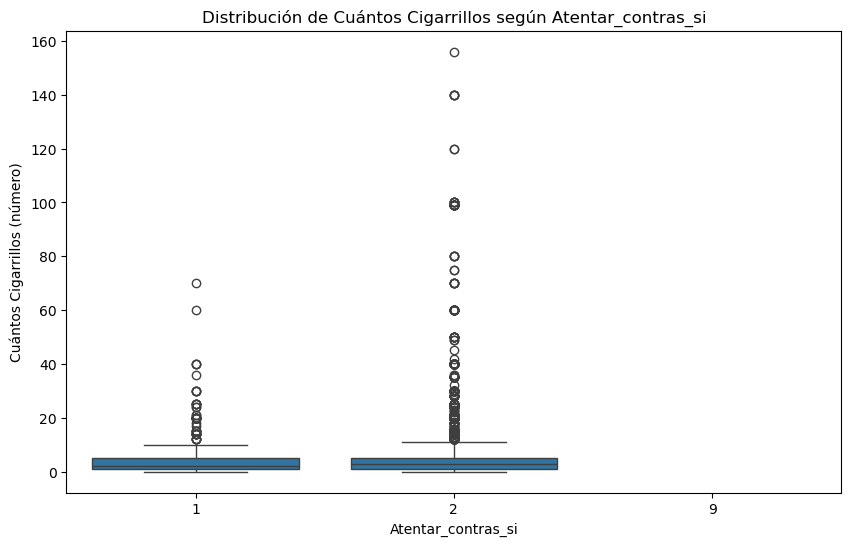

In [104]:
# Box plot para ver la distribución de 'Cuantos cigarrillos (numero)' según Atentar_contras_si
plt.figure(figsize=(10, 6))
sns.boxplot(x='Atentar_contras_si', y='Cuantos cigarrillos (numero)', data=df_1)
plt.title('Distribución de Cuántos Cigarrillos según Atentar_contras_si')
plt.xlabel('Atentar_contras_si')
plt.ylabel('Cuántos Cigarrillos (número)')
plt.show()

We can also see how age is distributed in the "Tristeza" variable:

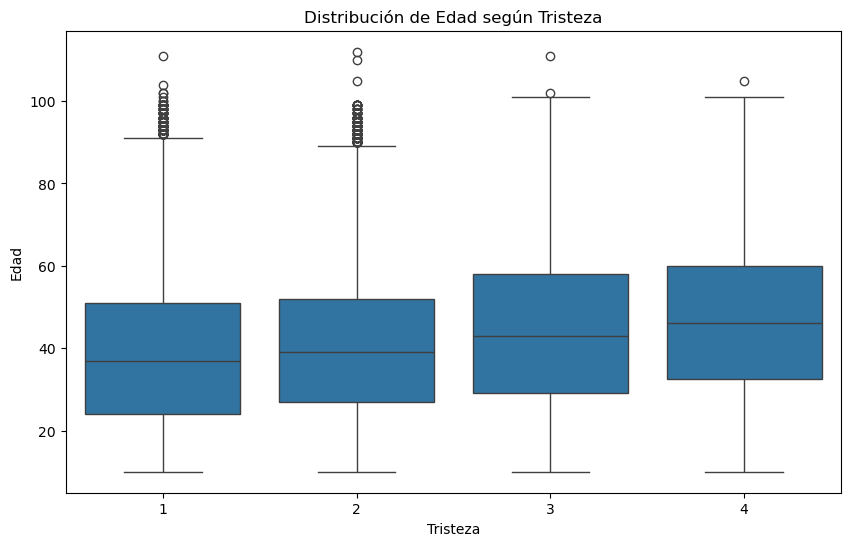

In [105]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tristeza', y='Edad', data=df_1)
plt.title('Distribución de Edad según Tristeza')
plt.xlabel('Tristeza')
plt.ylabel('Edad')
plt.show()

We can do the same with Age and the "Depresion" column:

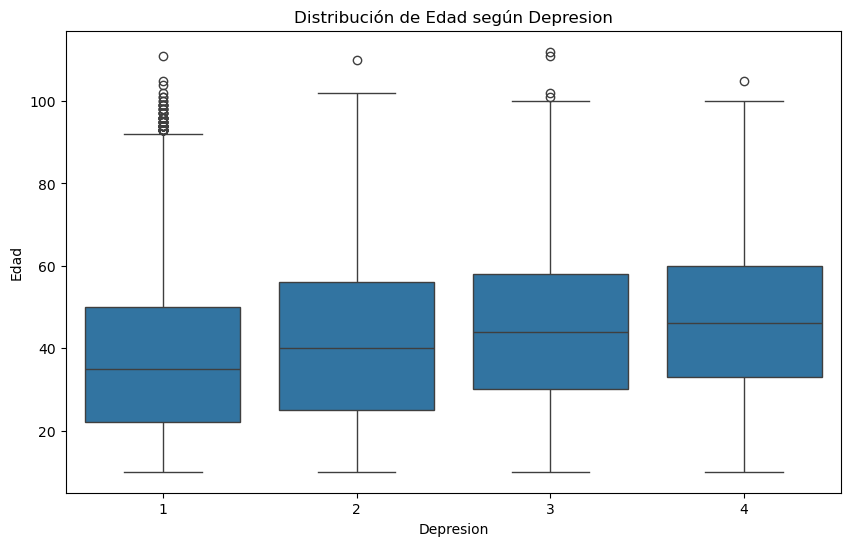

In [106]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Depresion', y='Edad', data=df_1)
plt.title('Distribución de Edad según Depresion')
plt.xlabel('Depresion')
plt.ylabel('Edad')
plt.show()

Finally, see how age is distributed in the variable "Atentar_contras_si"

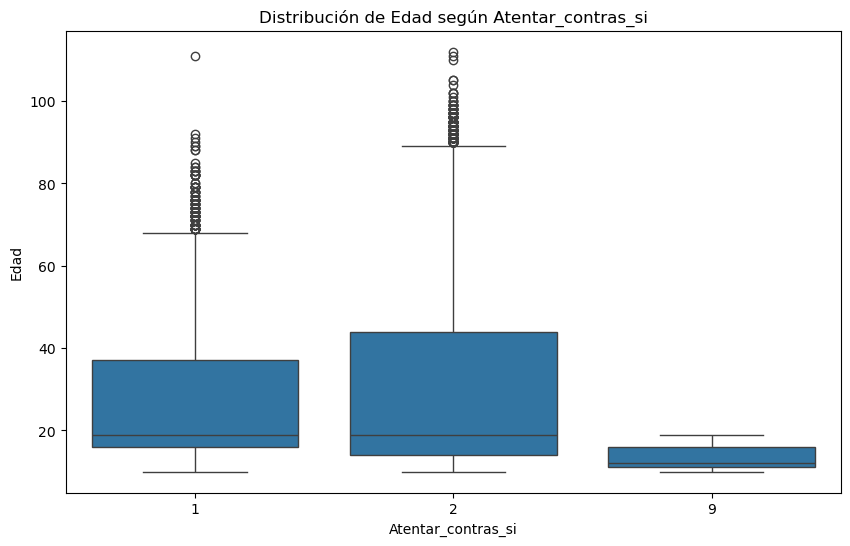

In [107]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Atentar_contras_si', y='Edad', data=df_1)
plt.title('Distribución de Edad según Atentar_contras_si')
plt.xlabel('Atentar_contras_si')
plt.ylabel('Edad')
plt.show()

### Comments

According to what was observed with the boxplots, we see that what is described in the correlation part is confirmed, since it seems that the number of cigarettes consumed per week is not important for our categorical variables. The average number of cigarettes is similar for each group of responses.


Regarding the distribution of age on our categorical variables, we can observe that the average age of the saddest and most depressed people is between 40 and 50 years. While the average age of Mexicans who tried to take their own life is approximately 19 years.


## Geographic distribution

This section shows some maps and interactive graphs, which group by state and average by year some of our variables.

### Note:
Although the color of some states of the Mexican Republic turn out to be very dark in some years, we must not forget the amount of missing data, the difference in surveys carried out per year and that the average can be low, the following is shown only as a perspective regarding the other states of the Mexican Republic.


We start by declaring some variables and doing a merge with the shp that contains the geometry of the states of Mexico.

In [108]:
# Cargar el shapefile de México
path = os.path.join('..', 'data', 'raw', 'MAPA', '2023_1_00_ENT.shp')
#path = os.path.join('/content/2023_1_00_ENT.shp')
mexico_map = gpd.read_file(path)

# Cambiar el nombre de la columna NOMGEO a Entidad en el shapefile para hacer coincidir con el DataFrame
mexico_map = mexico_map.rename(columns={'NOMGEO': 'Entidad'})

# Diccionario de correspondencias entre los nombres de entidades en 'Entidad' del DataFrame y 'Entidad' del shapefile
correspondencias = {
    'AGUASCALIENTES': 'Aguascalientes',
    'BAJA CALIFORNIA': 'Baja California',
    'BAJA CALIFORNIA SUR': 'Baja California Sur',
    'CAMPECHE': 'Campeche',
    'COAHUILA DE ZARAGOZA': 'Coahuila de Zaragoza',
    'COLIMA': 'Colima',
    'CHIAPAS': 'Chiapas',
    'CHIHUAHUA': 'Chihuahua',
    'CIUDAD DE MÉXICO': 'Ciudad de México',
    'DURANGO': 'Durango',
    'GUANAJUATO': 'Guanajuato',
    'GUERRERO': 'Guerrero',
    'HIDALGO': 'Hidalgo',
    'JALISCO': 'Jalisco',
    'MÉXICO': 'México',
    'MICHOACÁN DE OCAMPO': 'Michoacán de Ocampo',
    'MORELOS': 'Morelos',
    'NAYARIT': 'Nayarit',
    'NUEVO LEÓN': 'Nuevo León',
    'OAXACA': 'Oaxaca',
    'PUEBLA': 'Puebla',
    'QUERÉTARO': 'Querétaro',
    'QUINTANA ROO': 'Quintana Roo',
    'SAN LUIS POTOSÍ': 'San Luis Potosí',
    'SINALOA': 'Sinaloa',
    'SONORA': 'Sonora',
    'TABASCO': 'Tabasco',
    'TAMAULIPAS': 'Tamaulipas',
    'TLAXCALA': 'Tlaxcala',
    'VERACRUZ DE IGNACIO DE LA LLAVE': 'Veracruz de Ignacio de la Llave',
    'YUCATÁN': 'Yucatán',
    'ZACATECAS': 'Zacatecas'
}

# Reemplazar los valores en la columna 'Entidad' en el DataFrame con los valores correspondientes del diccionario
df_1['Entidad'] = df_1['Entidad'].replace(correspondencias)

The following map shows the states in perspective the average of an affirmative response to an attempt to take their own life throughout all the years in which the survey was administered.

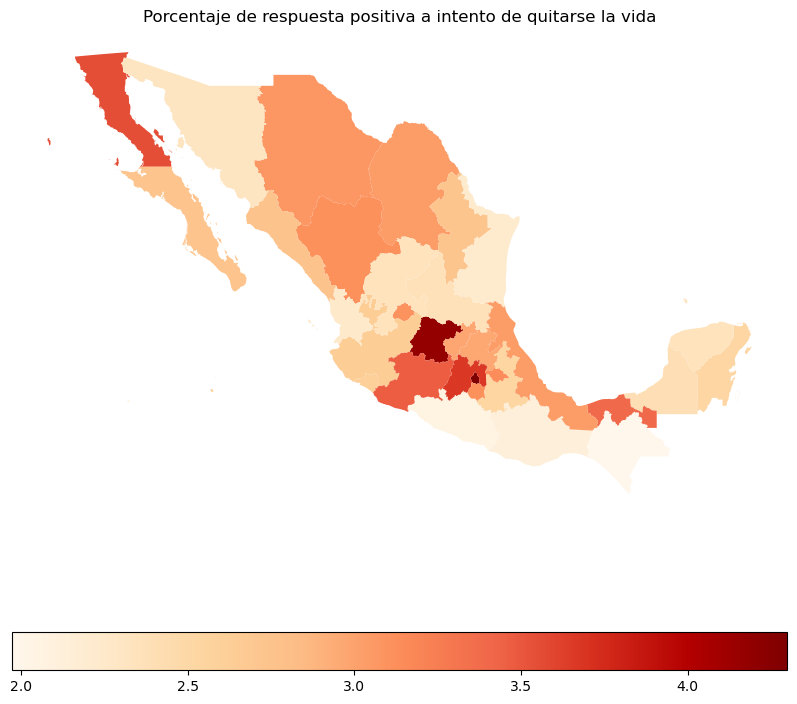

In [109]:
percentages_1 = df_1[(df_1['Atentar_contras_si'].notna()) & ((df_1['Atentar_contras_si'] == '1'))] \
    .groupby('Entidad').size() * 100 / df_1[df_1['Atentar_contras_si'].notna()].groupby('Entidad').size()


# Convertir el resultado a DataFrame y resetear el índice para poder hacer la combinación
percentages_1 = percentages_1.reset_index()
percentages_1.columns = ['Entidad', 'Porcentaje_1']

# Realizar la combinación entre el shapefile y los datos de porcentaje
mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

# Convertir mexico_data_sample en un GeoDataFrame
mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))

# Añadir título y otros detalles al mapa
plt.title("Porcentaje de respuesta positiva a intento de quitarse la vida")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
mexico_data_sample.plot(column='Porcentaje_1', cmap='OrRd', legend=True,legend_kwds={'orientation': "horizontal"}, missing_kwds={"color": "lightgrey"},ax=ax)
ax.set_axis_off()

This graph also shows the positive response, however it is divided by years.

In [110]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Atentar_contras_si'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar las barras horizontales con Seaborn
def plot_horizontal_bars(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Atentar_contras_si'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad
    percentages_1 = data_anio[data_anio['Atentar_contras_si'] == '1'] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y ordenar por porcentaje
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']
    percentages_1 = percentages_1.sort_values('Porcentaje_1', ascending=False)

    # Crear una paleta de colores continua
    palette = sns.color_palette('Blues_r', n_colors=len(percentages_1))

    # Crear la gráfica de barras horizontales con Seaborn
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=percentages_1,
        y='Entidad',
        x='Porcentaje_1',
        hue='Entidad',  # Asignar 'Entidad' al parámetro hue para evitar el FutureWarning
        palette=palette,  # Usar la paleta continua
        dodge=False,  # Asegurarse de que las barras no se desplacen
        legend=False  # Desactivar la leyenda ya que no es necesaria
    )

    plt.ylabel('Entidad')
    plt.title(f'Porcentaje de respuesta positiva a intento de quitarse la vida - Año {anio.astype(int)}')
    plt.xlabel("")
    sns.despine(bottom=True)  # Eliminar bordes para un diseño limpio

    # Quitar los valores del eje X
    ax.set_xticks([])

    plt.show()

# Crear un Dropdown para seleccionar el año
anio_dropdown = widgets.Dropdown(options=anios_disponibles, description='Año:')

# Conectar la gráfica a la interactividad
interact(plot_horizontal_bars, anio=anio_dropdown)


interactive(children=(Dropdown(description='Año:', options=(2006.0, 2012.0, 2018.0, 2020.0, 2021.0, 2022.0, 20…

<function __main__.plot_horizontal_bars(anio)>

The following interactive map is another way to visualize the previous graph.

In [111]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Atentar_contras_si'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar el mapa de un año específico
def plot_map(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Atentar_contras_si'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad en la columna 'Atentar_contras_si'
    percentages_1 = data_anio[data_anio['Atentar_contras_si'] == '1'] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y resetear el índice para poder hacer la combinación
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']

    # Realizar la combinación entre el shapefile y los datos de porcentaje
    mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
    mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Porcentaje_1'
    mexico_data_sample.plot(column='Porcentaje_1', cmap='OrRd', legend=True,legend_kwds={'orientation': "horizontal"}, missing_kwds={"color": "lightgrey"},ax=ax)

    # Añadir título y otros detalles al mapa
    plt.title(f"Porcentaje de respuesta positiva a intento de quitarse la vida - Año {anio.astype('int')}")
    ax.set_axis_off()

    # Mostrar el mapa
    plt.show()

# Crear un control deslizante de años y conectarlo a la función de graficación
interact(plot_map, anio=widgets.Dropdown(options=anios_disponibles, description='Año:'))


interactive(children=(Dropdown(description='Año:', options=(2006.0, 2012.0, 2018.0, 2020.0, 2021.0, 2022.0, 20…

<function __main__.plot_map(anio)>

Let's analyze the same thing but now with the variable "Depresion", this time we consider the averages of each state in which the person answered feeling sad for three or more days a week:

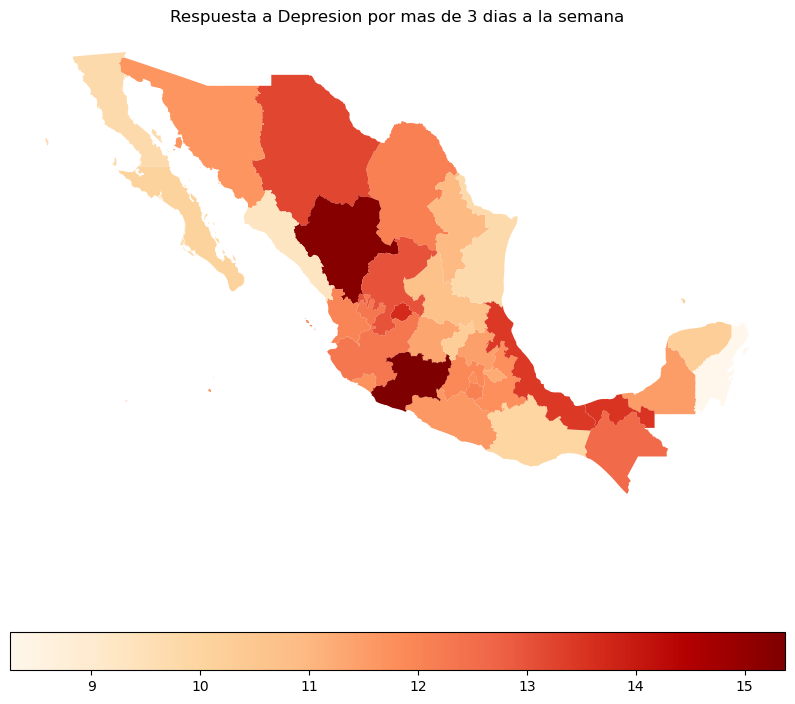

In [112]:
# Filtrar las filas donde 'Depresion' tiene valores '3' o '4'
filtered = df_1[(df_1['Depresion'].notna()) & ((df_1['Depresion'] == '4') | (df_1['Depresion'] == '3'))]

# Calcular el total de respuestas no nulas por entidad
total_responses = df_1[df_1['Depresion'].notna()].groupby('Entidad').size()

# Calcular el porcentaje por entidad
percentages_1 = filtered.groupby('Entidad').size() * 100 / total_responses

# Convertir el resultado en un DataFrame para facilitar el merge
percentages_1 = percentages_1.reset_index()
percentages_1.columns = ['Entidad', 'Porcentaje_1']

# Realizar la combinación entre el shapefile y los datos de porcentaje
mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

# Convertir mexico_data_sample en un GeoDataFrame
mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

# Generar el mapa
fig, ax = plt.subplots(figsize=(10, 10))

mexico_data_sample.plot(
    column='Porcentaje_1',
    cmap='OrRd',
    legend=True,
    legend_kwds={'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

# Añadir título y detalles
plt.title("Respuesta a Depresion por mas de 3 dias a la semana")
ax.set_axis_off()

# Mostrar el mapa
plt.show()


The interactive graph by years:

In [113]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Depresion'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar las barras horizontales con Seaborn
def plot_horizontal_bars(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Depresion'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad
    percentages_1 = data_anio[(data_anio['Depresion'] == '3') | (data_anio['Depresion'] == '4')] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y ordenar por porcentaje
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']
    percentages_1 = percentages_1.sort_values('Porcentaje_1', ascending=False)

    # Crear una paleta de colores continua
    palette = sns.color_palette('Blues_r', n_colors=len(percentages_1))

    # Crear la gráfica de barras horizontales con Seaborn
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=percentages_1,
        y='Entidad',
        x='Porcentaje_1',
        hue='Entidad',  # Asignar 'Entidad' al parámetro hue para evitar el FutureWarning
        palette=palette,  # Usar la paleta continua
        dodge=False,  # Asegurarse de que las barras no se desplacen
        legend=False  # Desactivar la leyenda ya que no es necesaria
    )

    plt.ylabel('Entidad')
    plt.title(f'Respuesta a Depresion por mas de 3 dias a la semana - Año {anio.astype(int)}')
    plt.xlabel("")
    sns.despine(bottom=True)  # Eliminar bordes para un diseño limpio

    # Quitar los valores del eje X
    ax.set_xticks([])

    plt.show()

# Crear un Dropdown para seleccionar el año
anio_dropdown = widgets.Dropdown(options=anios_disponibles, description='Año:')

# Conectar la gráfica a la interactividad
interact(plot_horizontal_bars, anio=anio_dropdown)


interactive(children=(Dropdown(description='Año:', options=(2012.0, 2018.0, 2021.0, 2022.0, 2023.0), value=201…

<function __main__.plot_horizontal_bars(anio)>


And the interactive map for years.

In [114]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Depresion'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar el mapa de un año específico
def plot_map(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Depresion'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad en la columna 'Atentar_contras_si'
    percentages_1 = data_anio[(data_anio['Depresion'] == '4')|(data_anio['Depresion'] == '3')] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y resetear el índice para poder hacer la combinación
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']

    # Realizar la combinación entre el shapefile y los datos de porcentaje
    mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
    mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Porcentaje_1'
    mexico_data_sample.plot(column='Porcentaje_1', cmap='OrRd', legend=True,legend_kwds={'orientation': "horizontal"}, missing_kwds={"color": "lightgrey"},ax=ax)

    # Añadir título y otros detalles al mapa
    plt.title(f"Respuesta a Depresion por mas de 3 dias a la semana - Año {anio.astype('int')}")
    ax.set_axis_off()

    # Mostrar el mapa
    plt.show()

# Crear un control deslizante de años y conectarlo a la función de graficación
interact(plot_map, anio=widgets.Dropdown(options=anios_disponibles, description='Año:'))


interactive(children=(Dropdown(description='Año:', options=(2012.0, 2018.0, 2021.0, 2022.0, 2023.0), value=201…

<function __main__.plot_map(anio)>

Let's now see what happens with the average of the "Tristeza" variable throughout the country.

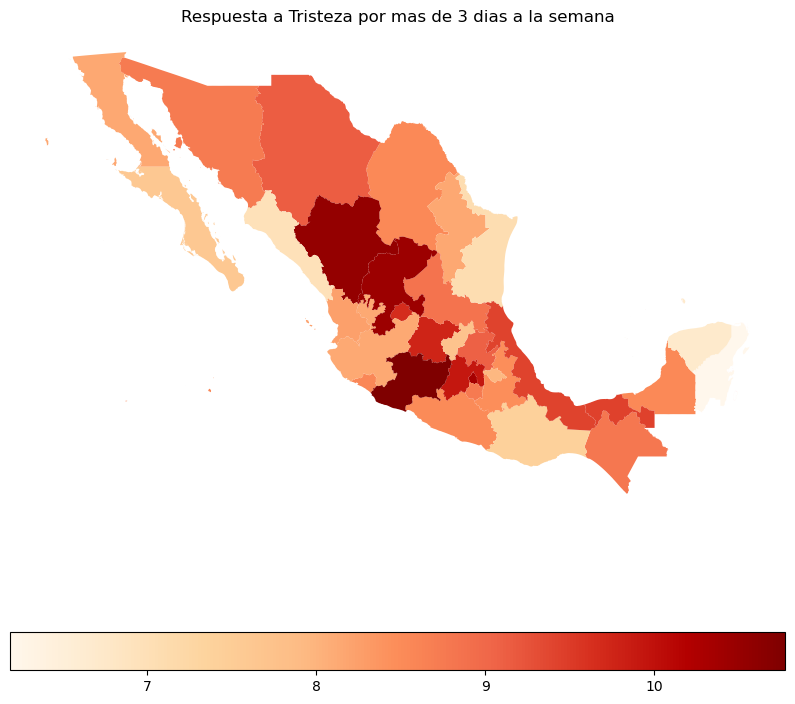

In [115]:
# Filtrar las filas donde 'Depresion' tiene valores '3' o '4'
filtered = df_1[(df_1['Tristeza'].notna()) & ((df_1['Tristeza'] == '4') | (df_1['Tristeza'] == '3'))]

# Calcular el total de respuestas no nulas por entidad
total_responses = df_1[df_1['Tristeza'].notna()].groupby('Entidad').size()

# Calcular el porcentaje por entidad
percentages_1 = filtered.groupby('Entidad').size() * 100 / total_responses

# Convertir el resultado en un DataFrame para facilitar el merge
percentages_1 = percentages_1.reset_index()
percentages_1.columns = ['Entidad', 'Porcentaje_1']

# Realizar la combinación entre el shapefile y los datos de porcentaje
mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

# Convertir mexico_data_sample en un GeoDataFrame
mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

# Generar el mapa
fig, ax = plt.subplots(figsize=(10, 10))

mexico_data_sample.plot(
    column='Porcentaje_1',
    cmap='OrRd',
    legend=True,
    legend_kwds={'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

# Añadir título y detalles
plt.title("Respuesta a Tristeza por mas de 3 dias a la semana")
ax.set_axis_off()

# Mostrar el mapa
plt.show()


Let's visualize on a graph what happens over the years.

In [116]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Tristeza'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar las barras horizontales con Seaborn
def plot_horizontal_bars(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Tristeza'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad
    percentages_1 = data_anio[(data_anio['Tristeza'] == '3') | (data_anio['Tristeza'] == '4')] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y ordenar por porcentaje
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']
    percentages_1 = percentages_1.sort_values('Porcentaje_1', ascending=False)

    # Crear una paleta de colores continua
    palette = sns.color_palette('Blues_r', n_colors=len(percentages_1))

    # Crear la gráfica de barras horizontales con Seaborn
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=percentages_1,
        y='Entidad',
        x='Porcentaje_1',
        hue='Entidad',  # Asignar 'Entidad' al parámetro hue para evitar el FutureWarning
        palette=palette,  # Usar la paleta continua
        dodge=False,  # Asegurarse de que las barras no se desplacen
        legend=False  # Desactivar la leyenda ya que no es necesaria
    )

    plt.ylabel('Entidad')
    plt.title(f'Respuesta a Tristeza por mas de 3 dias a la semana - Año {anio.astype(int)}')
    plt.xlabel("")
    sns.despine(bottom=True)  # Eliminar bordes para un diseño limpio

    # Quitar los valores del eje X
    ax.set_xticks([])

    plt.show()

# Crear un Dropdown para seleccionar el año
anio_dropdown = widgets.Dropdown(options=anios_disponibles, description='Año:')

# Conectar la gráfica a la interactividad
interact(plot_horizontal_bars, anio=anio_dropdown)


interactive(children=(Dropdown(description='Año:', options=(2006.0, 2012.0, 2018.0, 2021.0, 2022.0, 2023.0), v…

<function __main__.plot_horizontal_bars(anio)>

Let's see what happens with the interactive map in each of the years.

In [117]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Encontrar los años únicos con datos no nulos en 'Atentar_contras_si'
anios_disponibles = df_1[df_1['Tristeza'].notna()]['Anio'].unique()
anios_disponibles.sort()

# Función para graficar el mapa de un año específico
def plot_map(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio'] == anio) & (df_1['Tristeza'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad en la columna 'Atentar_contras_si'
    percentages_1 = data_anio[(data_anio['Tristeza'] == '4')|(data_anio['Tristeza'] == '3')] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y resetear el índice para poder hacer la combinación
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']

    # Realizar la combinación entre el shapefile y los datos de porcentaje
    mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
    mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Porcentaje_1'
    mexico_data_sample.plot(column='Porcentaje_1', cmap='OrRd', legend=True,legend_kwds={'orientation': "horizontal"}, missing_kwds={"color": "lightgrey"},ax=ax)

    # Añadir título y otros detalles al mapa
    plt.title(f"Respuesta a tristeza por mas de 3 dias a la semana - Año {anio.astype('int')}")
    ax.set_axis_off()

    # Mostrar el mapa
    plt.show()

# Crear un control deslizante de años y conectarlo a la función de graficación
interact(plot_map, anio=widgets.Dropdown(options=anios_disponibles, description='Año:'))


interactive(children=(Dropdown(description='Año:', options=(2006.0, 2012.0, 2018.0, 2021.0, 2022.0, 2023.0), v…

<function __main__.plot_map(anio)>

Finally, let's see what happens with the distribution of the percentage of alcoholic beverages consumed daily:

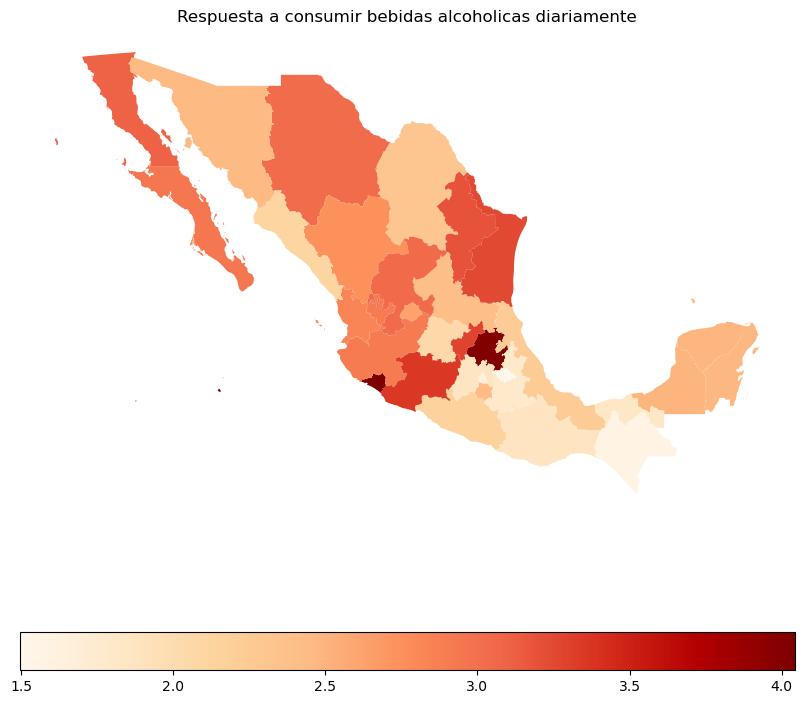

In [118]:
# Filtrar las filas donde 'Depresion' tiene valores '3' o '4'
filtered = df_1[(df_1['Frecuencia emborrachar'].notna()) & (df_1['Frecuencia emborrachar'] == '1')]

# Calcular el total de respuestas no nulas por entidad
total_responses = df_1[df_1['Frecuencia emborrachar'].notna()].groupby('Entidad').size()

# Calcular el porcentaje por entidad
percentages_1 = filtered.groupby('Entidad').size() * 100 / total_responses

# Convertir el resultado en un DataFrame para facilitar el merge
percentages_1 = percentages_1.reset_index()
percentages_1.columns = ['Entidad', 'Porcentaje_1']

# Realizar la combinación entre el shapefile y los datos de porcentaje
mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

# Convertir mexico_data_sample en un GeoDataFrame
mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

# Generar el mapa
fig, ax = plt.subplots(figsize=(10, 10))

mexico_data_sample.plot(
    column='Porcentaje_1',
    cmap='OrRd',
    legend=True,
    legend_kwds={'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

# Añadir título y detalles
plt.title("Respuesta a consumir bebidas alcoholicas diariamente")
ax.set_axis_off()

# Mostrar el mapa
plt.show()

Let's look at the previous map, described in a bar graph and by year:

In [119]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year

# Ajustar el año en df_1 creando una nueva columna 'Anio_Ajustado'
df_1['Anio_Ajustado'] = df_1['Anio'].replace({1999: 2000, 2001: 2000, 2008:2006})

# Filtrar los años únicos ajustados para el Dropdown, eliminando los valores nulos
anios_disponibles = sorted(df_1['Anio_Ajustado'].dropna().unique())




# Función para graficar las barras horizontales con Seaborn
def plot_horizontal_bars(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio_Ajustado'] == anio) & (df_1['Frecuencia emborrachar'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad
    percentages_1 = data_anio[data_anio['Frecuencia emborrachar'] == '1'] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y ordenar por porcentaje
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']
    percentages_1 = percentages_1.sort_values('Porcentaje_1', ascending=False)

    # Crear una paleta de colores continua
    palette = sns.color_palette('Blues_r', n_colors=len(percentages_1))

    # Crear la gráfica de barras horizontales con Seaborn
    plt.figure(figsize=(10, 8))
    ax = sns.barplot(
        data=percentages_1,
        y='Entidad',
        x='Porcentaje_1',
        hue='Entidad',  # Asignar 'Entidad' al parámetro hue para evitar el FutureWarning
        palette=palette,  # Usar la paleta continua
        dodge=False,  # Asegurarse de que las barras no se desplacen
        legend=False  # Desactivar la leyenda ya que no es necesaria
    )

    plt.ylabel('Entidad')
    plt.title(f'Respuesta positiva a tomar bebidas alcoholicas diariamente - Año {anio.astype(int)}')
    plt.xlabel("")
    sns.despine(bottom=True)  # Eliminar bordes para un diseño limpio

    # Quitar los valores del eje X
    ax.set_xticks([])

    plt.show()

# Crear un Dropdown para seleccionar el año
anio_dropdown = widgets.Dropdown(options=anios_disponibles, description='Año:')

# Conectar la gráfica a la interactividad
interact(plot_horizontal_bars, anio=anio_dropdown)


interactive(children=(Dropdown(description='Año:', options=(2000.0, 2006.0, 2012.0, 2018.0, 2020.0, 2021.0, 20…

<function __main__.plot_horizontal_bars(anio)>

We have an interactive map that shows us the previous graph in a different way.

In [120]:
# Ajustar el año en df_1 creando una nueva columna 'Anio_Ajustado'
df_1['Anio_Ajustado'] = df_1['Anio'].replace({1999: 2000, 2001: 2000, 2008:2006})

# Filtrar los años únicos ajustados para el Dropdown, eliminando los valores nulos
anios_disponibles = sorted(df_1['Anio_Ajustado'].dropna().unique())

# Función para graficar el mapa de un año específico usando 'Anio_Ajustado'
def plot_map(anio):
    # Filtrar los datos del año ajustado seleccionado
    data_anio = df_1[(df_1['Anio_Ajustado'] == anio) & (df_1['Frecuencia emborrachar'].notna())]

    # Calcular el porcentaje de respuesta "1" para cada entidad en la columna 'Frecuencia emborrachar'
    percentages_1 = data_anio[(data_anio['Frecuencia emborrachar'] == '1')] \
        .groupby('Entidad').size() * 100 / data_anio.groupby('Entidad').size()

    # Convertir el resultado a DataFrame y resetear el índice para poder hacer la combinación
    percentages_1 = percentages_1.reset_index()
    percentages_1.columns = ['Entidad', 'Porcentaje_1']

    # Realizar la combinación entre el shapefile y los datos de porcentaje
    mexico_data_sample = mexico_map.merge(percentages_1, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
    mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Porcentaje_1'
    mexico_data_sample.plot(column='Porcentaje_1', cmap='OrRd', legend=True,
                            legend_kwds={'orientation': "horizontal"},
                            missing_kwds={"color": "lightgrey"},
                            ax=ax)

    # Eliminar los ejes
    ax.set_axis_off()

    # Añadir título y otros detalles al mapa
    plt.title(f"Respuesta positiva a tomar bebidas alcoholicas diariamente - Año {anio.astype('int')}")

    # Mostrar el mapa
    plt.show()

# Crear un control Dropdown de años y conectarlo a la función de graficación
interact(plot_map, anio=widgets.Dropdown(options=anios_disponibles, description='Año:'))


interactive(children=(Dropdown(description='Año:', options=(2000.0, 2006.0, 2012.0, 2018.0, 2020.0, 2021.0, 20…

<function __main__.plot_map(anio)>

Finally, a map is shown with the averages of most cigarettes consumed per week in each of the states during all editions of the survey.

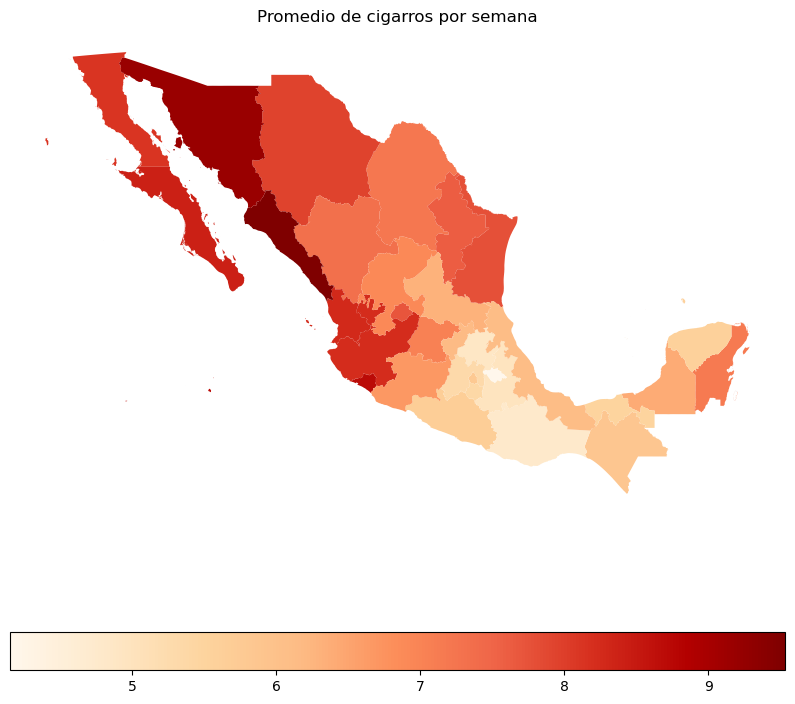

In [121]:
    # Filtrar los datos del año seleccionado
data_anio = df_1[df_1['Cuantos cigarrillos (numero)'].notna()]

    # Calcular el promedio de la columna 'Cuantos cigarrillos (numero)' por entidad
averages = data_anio.groupby('Entidad')['Cuantos cigarrillos (numero)'].mean().reset_index()
averages.columns = ['Entidad', 'Promedio_cigarros']

    # Convertir a numérico y manejar valores NaN
averages['Promedio_cigarros'] = pd.to_numeric(averages['Promedio_cigarros'], errors='coerce').fillna(-5)

    # Asegurarse de que la columna 'Promedio_cigarros' sea de tipo float
averages['Promedio_cigarros'] = averages['Promedio_cigarros'].astype(float)

    # Realizar la combinación entre el shapefile y los datos de promedio
mexico_data_sample = mexico_map.merge(averages, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Promedio_cigarros'
mexico_data_sample.plot(
    column='Promedio_cigarros',
    cmap='OrRd',
    legend=True,
    legend_kwds={'orientation': "horizontal"},
    missing_kwds={"color": "lightgrey"},
    ax=ax
)

    # Añadir título y otros detalles al mapa
plt.title(f"Promedio de cigarros por semana")
ax.set_axis_off()

    # Mostrar el mapa
plt.show()

Unlike the previous map, this one shows interaction, since it is possible to choose the year you want to view.

In [122]:
# Extraer el año de la columna Fecha y añadirlo como una nueva columna
df_1['Anio'] = pd.to_datetime(df_1['Fecha']).dt.year
df_1['Anio_Ajustado'] = df_1['Anio'].replace({1999: 2000, 2001: 2000})

# Filtrar los años únicos ajustados para el Dropdown, eliminando los valores nulos
anios_disponibles = sorted(df_1['Anio_Ajustado'].dropna().unique())

anios_disponibles.sort()

def plot_map(anio):
    # Filtrar los datos del año seleccionado
    data_anio = df_1[(df_1['Anio_Ajustado'] == anio) & (df_1['Cuantos cigarrillos (numero)'].notna())]

    # Calcular el promedio de la columna 'Cuantos cigarrillos (numero)' por entidad
    averages = data_anio.groupby('Entidad')['Cuantos cigarrillos (numero)'].mean().reset_index()
    averages.columns = ['Entidad', 'Promedio_cigarros']

    # Convertir a numérico y manejar valores NaN
    averages['Promedio_cigarros'] = pd.to_numeric(averages['Promedio_cigarros'], errors='coerce').fillna(-5)

    # Asegurarse de que la columna 'Promedio_cigarros' sea de tipo float
    averages['Promedio_cigarros'] = averages['Promedio_cigarros'].astype(float)

    # Realizar la combinación entre el shapefile y los datos de promedio
    mexico_data_sample = mexico_map.merge(averages, on='Entidad', how='left')

    # Convertir mexico_data_sample en un GeoDataFrame
    mexico_data_sample = gpd.GeoDataFrame(mexico_data_sample, geometry='geometry')

    fig, ax = plt.subplots(figsize=(10, 10))

    # Generar el mapa, coloreando según la columna 'Promedio_cigarros'
    mexico_data_sample.plot(
        column='Promedio_cigarros',
        cmap='OrRd',
        legend=True,
        legend_kwds={'orientation': "horizontal"},
        missing_kwds={"color": "lightgrey"},
        ax=ax
    )

    # Añadir título y otros detalles al mapa
    plt.title(f"Promedio de cigarros por semana - Año {anio.astype('int')}")
    ax.set_axis_off()

    # Mostrar el mapa
    plt.show()

# Crear un control Dropdown de años y conectarlo a la función de graficación
interact(plot_map, anio=widgets.Dropdown(options=anios_disponibles, description='Año:'))


interactive(children=(Dropdown(description='Año:', options=(2000.0, 2006.0, 2008.0, 2012.0, 2018.0, 2020.0, 20…

<function __main__.plot_map(anio)>

In [123]:
df_1.drop(columns=['Año','Año_ii', 'Anio', 'Anio_Ajustado'], inplace=True)

# Note.
There are still several analyzes that can be covered through graphs and maps, for example the distribution of our variables in minors or in different generations.

# Reduction of features for display

In this section we will apply methods to lower the dimensionality of our data.

Since our data is categorical, it is not convenient for us to do a PCA method, rather a method like t-SNE or UMAP is convenient for us.

Let's remember that we already have imputed columns, so it is not necessary to reformat the columns.

## UMAP


In the next cell we do the UMAP method:

In [124]:
# Seleccionar las columnas importantes
selected_columns = ['Edad_ii', 'Sexo', 'C_Entidad', 'Atentar_contras_si_ii', 'Depresion_ii', 'Tristeza_ii', 'Cuantos cigarrillos (numero)_ii', 'Frecuencia emborrachar_ii', 'Fecha_ii']

# Crear el subdataframe con las columnas seleccionadas y eliminar filas con valores faltantes
sub_df_1 = df_1[selected_columns].dropna()

# Convertir la columna 'Fecha' a 'Año'
sub_df_1['Fecha_ii'] = pd.to_datetime(sub_df_1['Fecha_ii'], errors='coerce')
sub_df_1['Año_ii'] = sub_df_1['Fecha_ii'].dt.year

# Eliminar la columna 'Fecha' ya que ahora tenemos 'Año'
sub_df_1.drop(columns=['Fecha_ii'], inplace=True)

# Codificar variables categóricas usando OneHotEncoder
categorical_cols_1 = ['Sexo', 'C_Entidad', 'Atentar_contras_si_ii', 'Depresion_ii', 'Tristeza_ii', 'Frecuencia emborrachar_ii']
sub_df_encoded_1 = pd.get_dummies(sub_df_1, columns=categorical_cols_1)

# Seleccionar solo las columnas numéricas para la reducción de dimensiones
num_cols_1 = sub_df_encoded_1.select_dtypes(include=[np.number]).columns
data_to_reduce_1 = sub_df_encoded_1[num_cols_1]

# Escalar los datos
scaler_1 = StandardScaler()
data_scaled_1 = scaler_1.fit_transform(data_to_reduce_1)


# Aplicar UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_results = umap_model.fit_transform(data_scaled_1)

C:\Users\DELL\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Let's see what columns df_encoded has to be able to graph:

In [125]:
print(sub_df_encoded_1.columns)

Index(['Edad_ii', 'Cuantos cigarrillos (numero)_ii', 'Año_ii', 'Sexo_1',
       'Sexo_2', 'C_Entidad_1', 'C_Entidad_2', 'C_Entidad_3', 'C_Entidad_4',
       'C_Entidad_5', 'C_Entidad_6', 'C_Entidad_7', 'C_Entidad_8',
       'C_Entidad_9', 'C_Entidad_10', 'C_Entidad_11', 'C_Entidad_12',
       'C_Entidad_13', 'C_Entidad_14', 'C_Entidad_15', 'C_Entidad_16',
       'C_Entidad_17', 'C_Entidad_18', 'C_Entidad_19', 'C_Entidad_20',
       'C_Entidad_21', 'C_Entidad_22', 'C_Entidad_23', 'C_Entidad_24',
       'C_Entidad_25', 'C_Entidad_26', 'C_Entidad_27', 'C_Entidad_28',
       'C_Entidad_29', 'C_Entidad_30', 'C_Entidad_31', 'C_Entidad_32',
       'Atentar_contras_si_ii_1', 'Atentar_contras_si_ii_2',
       'Atentar_contras_si_ii_9', 'Depresion_ii_1', 'Depresion_ii_2',
       'Depresion_ii_3', 'Depresion_ii_4', 'Tristeza_ii_1', 'Tristeza_ii_2',
       'Tristeza_ii_3', 'Tristeza_ii_4', 'Frecuencia emborrachar_ii_1',
       'Frecuencia emborrachar_ii_2', 'Frecuencia emborrachar_ii_3',
       'F


Let's see how our data looks in the columns and the values ​​that were most related according to the Spearman correlation, let's see:
1. Self-harm intentions and Year.

2. Depression and Sadness.

3. Self-harm intentions and Depression.

4. Age and Sadness.

5. Frequency of drunkenness and Age.

6. How many cigarettes (number) and Age.

7. Year and Depression.
 
First, let's see Self-harm intentions and Year 

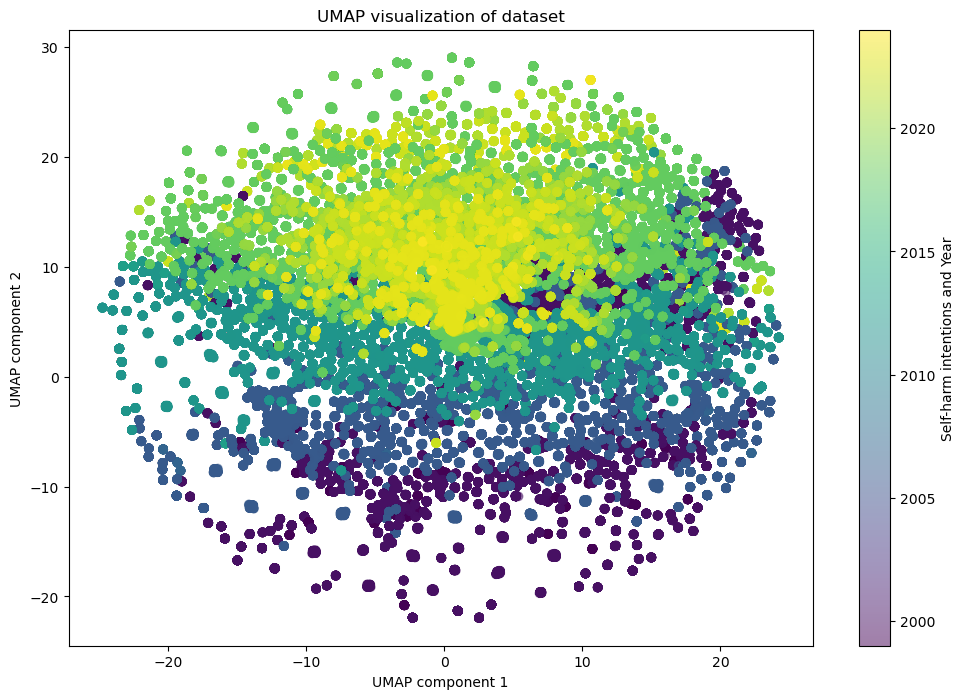

In [126]:
one = sub_df_encoded_1[['Año_ii', 'Atentar_contras_si_ii_1']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=one, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Self-harm intentions and Year')
plt.show()

Le'ts see Depression and Sadness

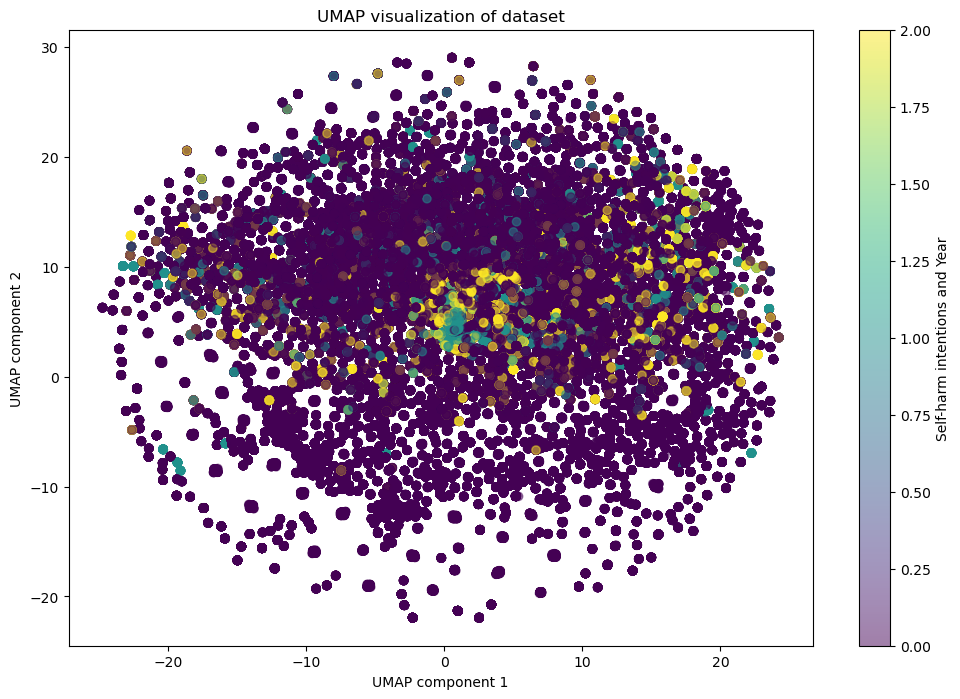

In [127]:
six = sub_df_encoded_1[['Depresion_ii_3', 'Depresion_ii_4','Tristeza_ii_3', 'Tristeza_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=six, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Self-harm intentions and Year')
plt.show()

Now, Self-harm intentions and Depression:

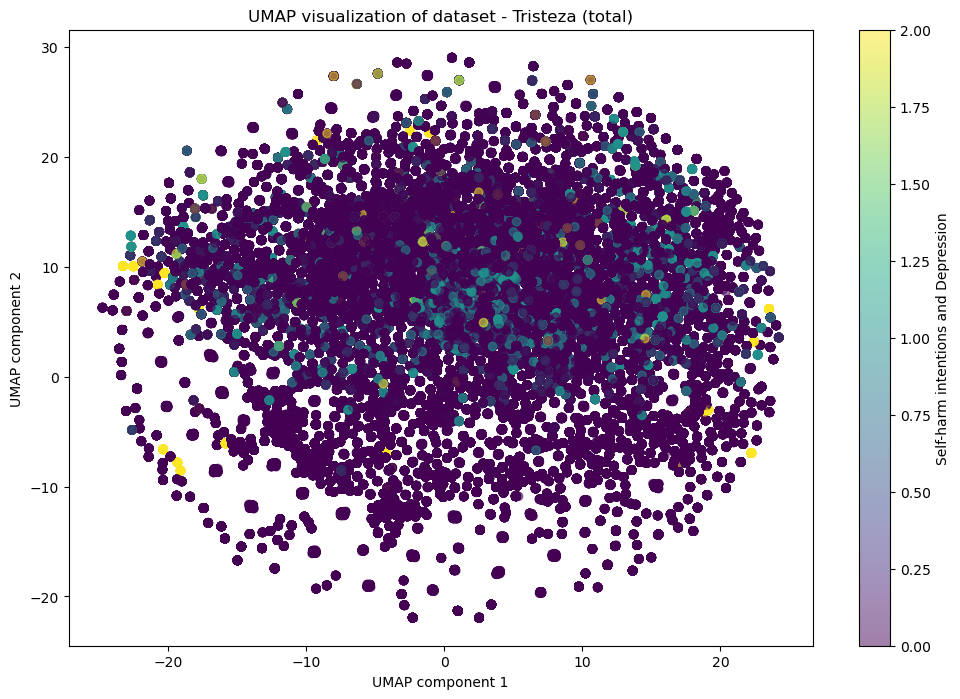

In [129]:
second = sub_df_encoded_1[['Atentar_contras_si_ii_1','Depresion_ii_3', 'Depresion_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=second, cmap='viridis')
plt.title('UMAP visualization of dataset - Tristeza (total)')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Self-harm intentions and Depression')
plt.show()

Let's see Age and Sadness:

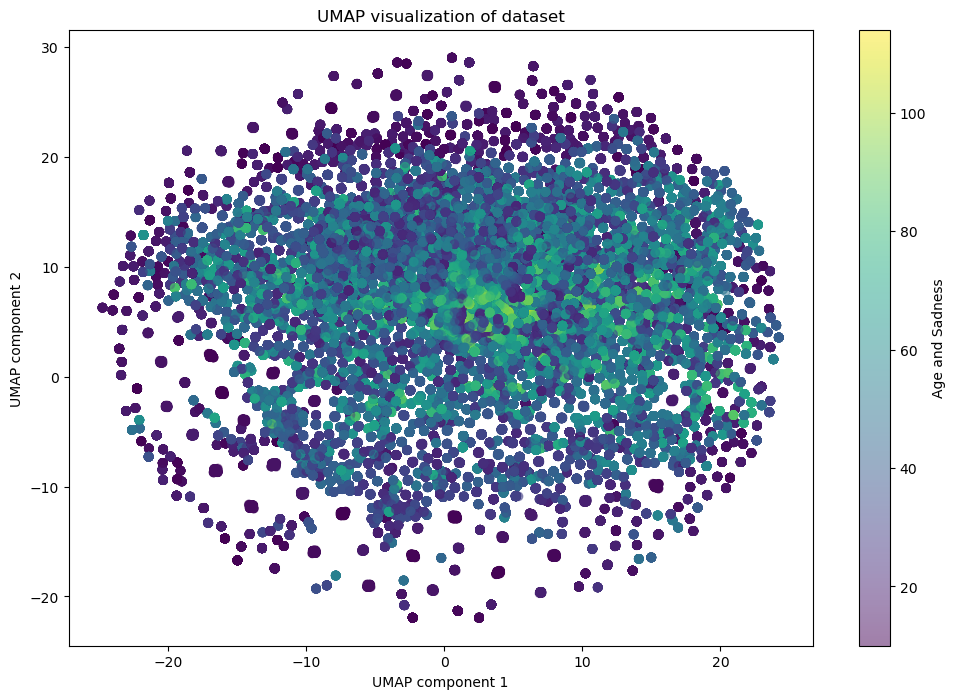

In [130]:
# Visualizar UMAP
thrird = sub_df_encoded_1[['Edad_ii','Tristeza_ii_3', 'Tristeza_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=thrird, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Age and Sadness')
plt.show()

Now, Frequency of drunkenness and Age

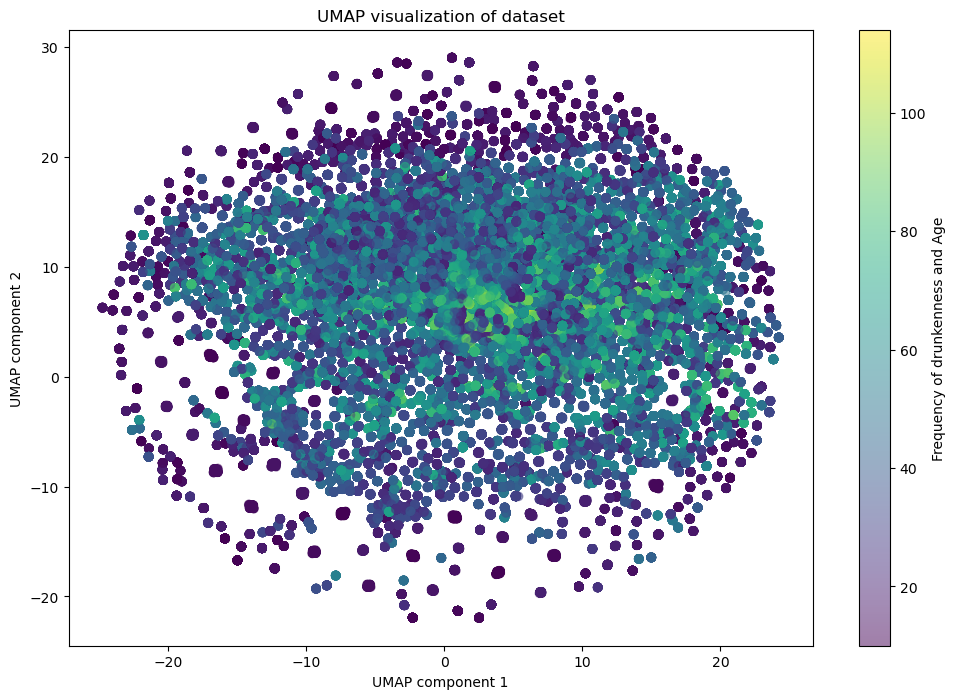

In [131]:
# Visualizar UMAP
fourth = sub_df_encoded_1[['Frecuencia emborrachar_ii_1','Edad_ii']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=fourth, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Frequency of drunkenness and Age')
plt.show()

How about that...How many cigarettes (number) and Age

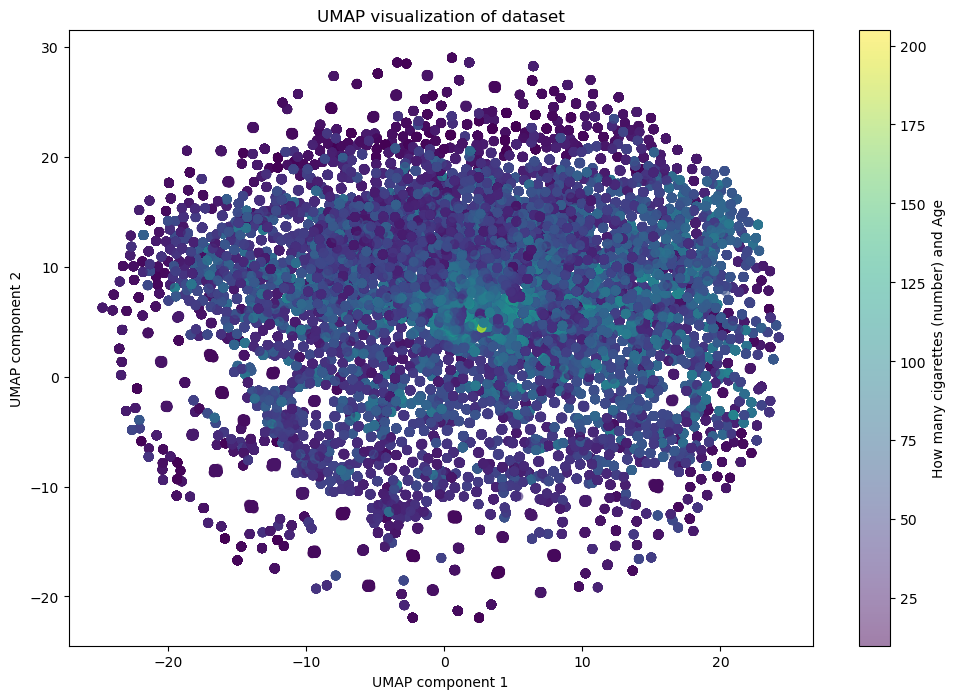

In [132]:
fifth = sub_df_encoded_1[['Cuantos cigarrillos (numero)_ii','Edad_ii']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=fifth, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='How many cigarettes (number) and Age')
plt.show()

Finally, Year and Depression

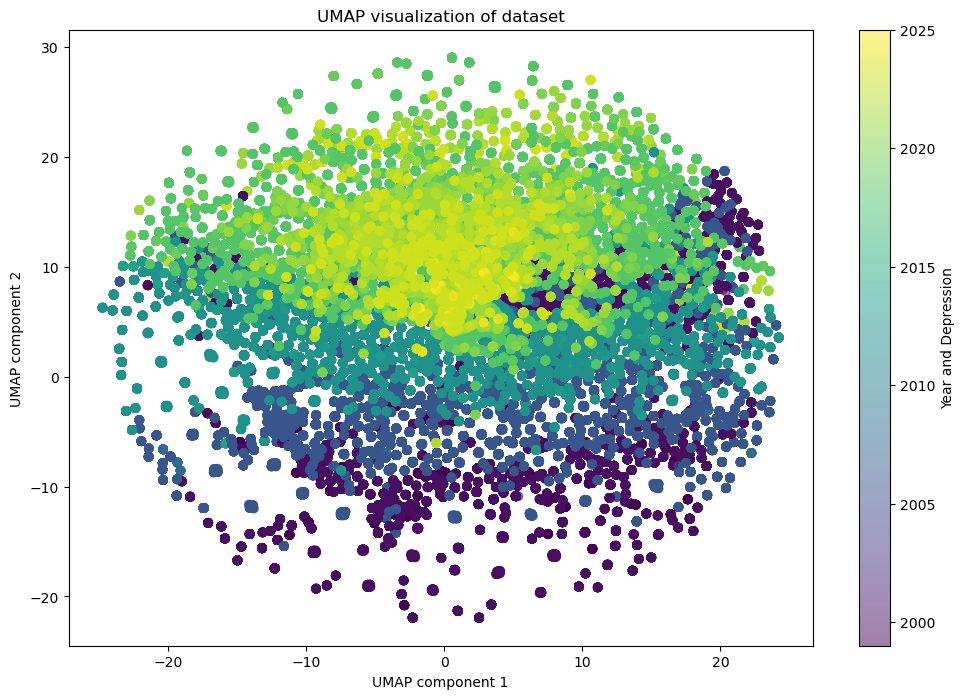

In [133]:
seven= sub_df_encoded_1[['Año_ii','Depresion_ii_3', 'Depresion_ii_3']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=seven, cmap='viridis')
plt.title('UMAP visualization of dataset')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Year and Depression')
plt.show()

Let's see how the states of the Mexican Republic are distributed on the data:

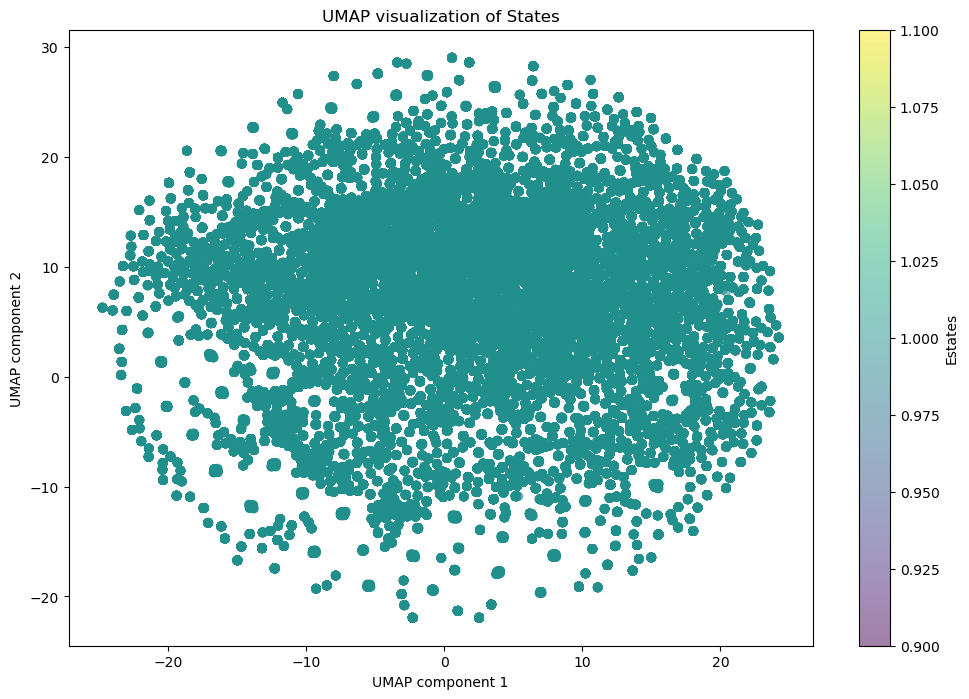

In [135]:
estados = sub_df_encoded_1[['C_Entidad_1', 'C_Entidad_2', 'C_Entidad_3', 'C_Entidad_4',
                          'C_Entidad_5', 'C_Entidad_6','C_Entidad_7', 'C_Entidad_8',
                          'C_Entidad_9', 'C_Entidad_10', 'C_Entidad_11', 'C_Entidad_12',
                          'C_Entidad_13', 'C_Entidad_14', 'C_Entidad_15', 'C_Entidad_16',
                          'C_Entidad_17', 'C_Entidad_18', 'C_Entidad_19', 'C_Entidad_20',
                          'C_Entidad_21', 'C_Entidad_22', 'C_Entidad_23', 'C_Entidad_24',
                          'C_Entidad_25', 'C_Entidad_26', 'C_Entidad_27', 'C_Entidad_28',
                          'C_Entidad_29', 'C_Entidad_30', 'C_Entidad_31', 'C_Entidad_32']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, c=estados, cmap='viridis')
plt.title('UMAP visualization of States')
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')
plt.colorbar(label='Estates')
plt.show()

## t-SNE

Now let's do a visualization with the t-SNE algorithm:

In [136]:
# Seleccionar las columnas importantes
selected_columns = ['Edad_ii', 'Sexo', 'C_Entidad', 'Atentar_contras_si_ii', 'Depresion_ii', 'Tristeza_ii', 'Cuantos cigarrillos (numero)_ii', 'Frecuencia emborrachar_ii', 'Fecha_ii']

# Crear el subdataframe con las columnas seleccionadas y eliminar filas con valores faltantes
sub_df_2 = df_1[selected_columns].dropna()

# Convertir la columna 'Fecha' a 'Año' y eliminar 'Fecha_ii'
sub_df_2['Fecha_ii'] = pd.to_datetime(sub_df_2['Fecha_ii'], errors='coerce')
sub_df_2.dropna(subset=['Fecha_ii'], inplace=True)
sub_df_2['Año_ii'] = sub_df_2['Fecha_ii'].dt.year
sub_df_2.drop(columns=['Fecha_ii'], inplace=True)

# Codificar variables categóricas usando pd.get_dummies
categorical_cols_2 = ['Sexo', 'C_Entidad', 'Atentar_contras_si_ii', 'Depresion_ii', 'Tristeza_ii', 'Frecuencia emborrachar_ii']
sub_df_encoded_2 = pd.get_dummies(sub_df_2, columns=categorical_cols_2, drop_first=True)

# Seleccionar solo las columnas numéricas para la reducción de dimensiones
num_cols_2 = sub_df_encoded_2.select_dtypes(include=[np.number]).columns
data_to_reduce_2 = sub_df_encoded_2[num_cols_2]

# Escalar los datos
scaler_2 = StandardScaler()
data_scaled_2 = scaler_2.fit_transform(data_to_reduce_2)

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(data_scaled_1)

Let's see what column we have:

In [137]:
print(sub_df_encoded_2.columns)

Index(['Edad_ii', 'Cuantos cigarrillos (numero)_ii', 'Año_ii', 'Sexo_2',
       'C_Entidad_2', 'C_Entidad_3', 'C_Entidad_4', 'C_Entidad_5',
       'C_Entidad_6', 'C_Entidad_7', 'C_Entidad_8', 'C_Entidad_9',
       'C_Entidad_10', 'C_Entidad_11', 'C_Entidad_12', 'C_Entidad_13',
       'C_Entidad_14', 'C_Entidad_15', 'C_Entidad_16', 'C_Entidad_17',
       'C_Entidad_18', 'C_Entidad_19', 'C_Entidad_20', 'C_Entidad_21',
       'C_Entidad_22', 'C_Entidad_23', 'C_Entidad_24', 'C_Entidad_25',
       'C_Entidad_26', 'C_Entidad_27', 'C_Entidad_28', 'C_Entidad_29',
       'C_Entidad_30', 'C_Entidad_31', 'C_Entidad_32',
       'Atentar_contras_si_ii_2', 'Atentar_contras_si_ii_9', 'Depresion_ii_2',
       'Depresion_ii_3', 'Depresion_ii_4', 'Tristeza_ii_2', 'Tristeza_ii_3',
       'Tristeza_ii_4', 'Frecuencia emborrachar_ii_2',
       'Frecuencia emborrachar_ii_3', 'Frecuencia emborrachar_ii_4',
       'Frecuencia emborrachar_ii_5', 'Frecuencia emborrachar_ii_6'],
      dtype='object')


Finally, we will use t-SNE to have another perspective, and we will apply it for some cases which are briefly described in the title of the figure.

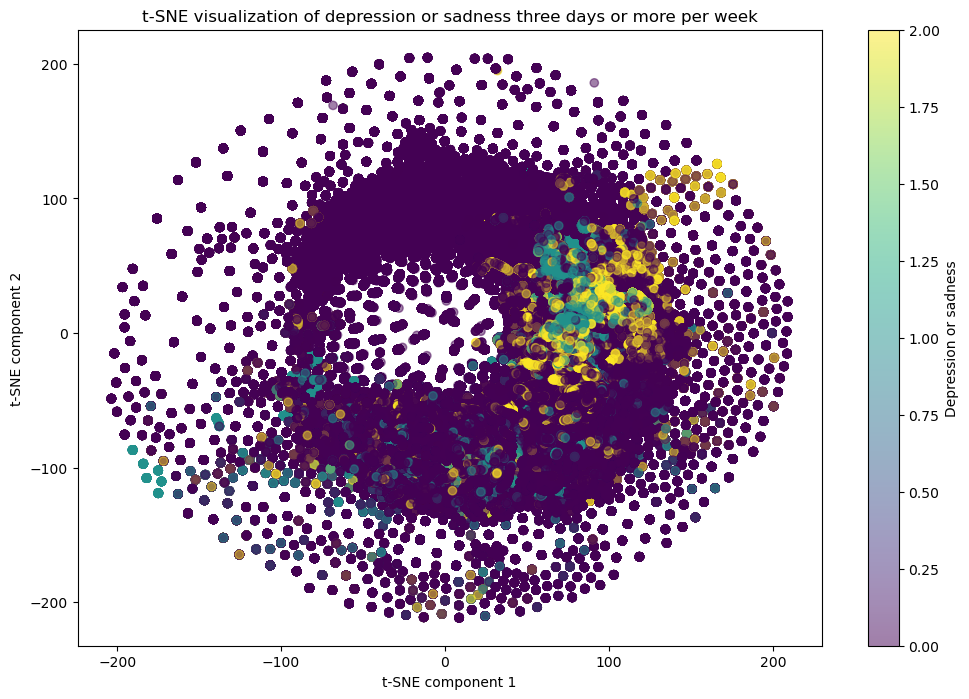

In [141]:
# Visualizar los resultados
dep_sad = sub_df_encoded_2[['Depresion_ii_3', 'Depresion_ii_4','Tristeza_ii_3','Tristeza_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=dep_sad, cmap='viridis')  # Ejemplo: colorear por 'Depresion_ii'
plt.title('t-SNE visualization of depression or sadness three days or more per week')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Depression or sadness')
plt.show()

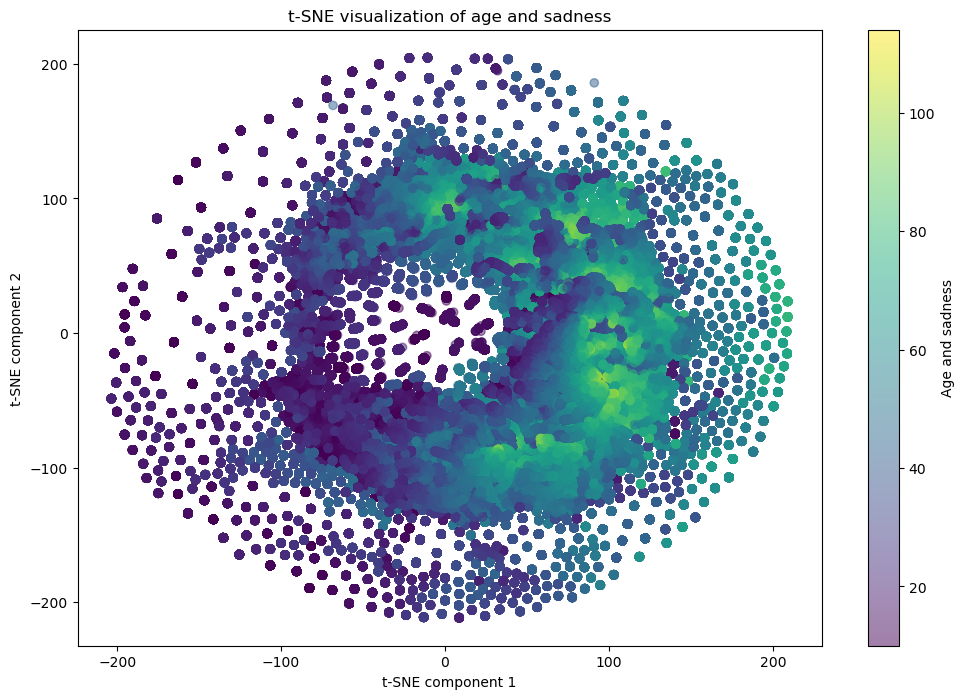

In [142]:
# Visualizar los resultados
age_sad = sub_df_encoded_2[['Edad_ii','Tristeza_ii_3', 'Tristeza_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=age_sad, cmap='viridis')  # Ejemplo: colorear por 'Depresion_ii'
plt.title('t-SNE visualization of age and sadness')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Age and sadness')
plt.show()

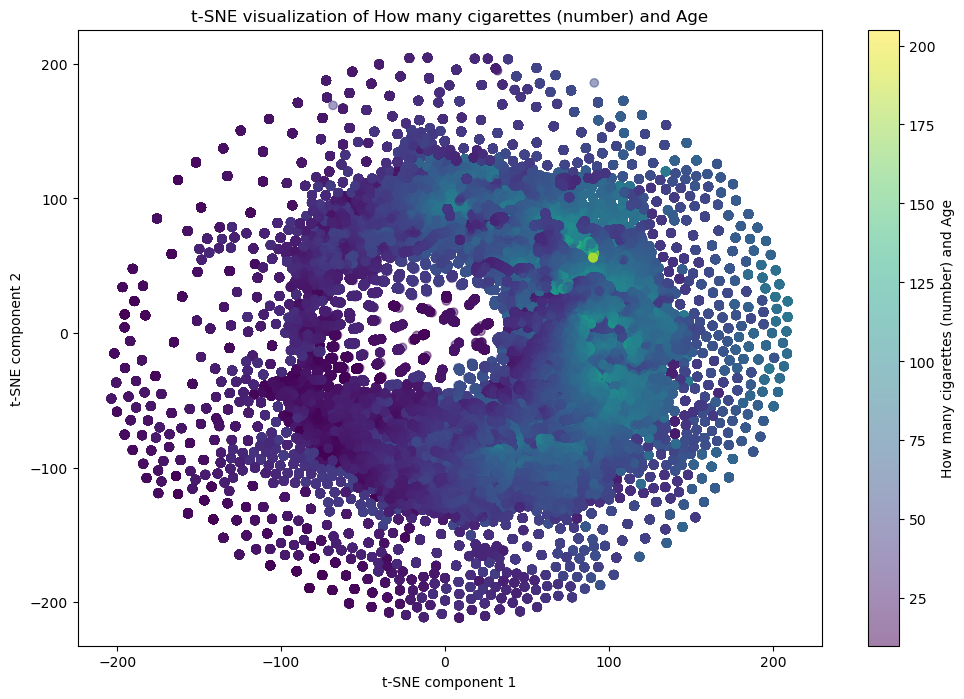

In [143]:
# Visualizar los resultados
num_age = sub_df_encoded_2[['Cuantos cigarrillos (numero)_ii','Edad_ii']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=num_age, cmap='viridis')  # Ejemplo: colorear por 'Depresion_ii'
plt.title('t-SNE visualization of How many cigarettes (number) and Age')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='How many cigarettes (number) and Age')
plt.show()

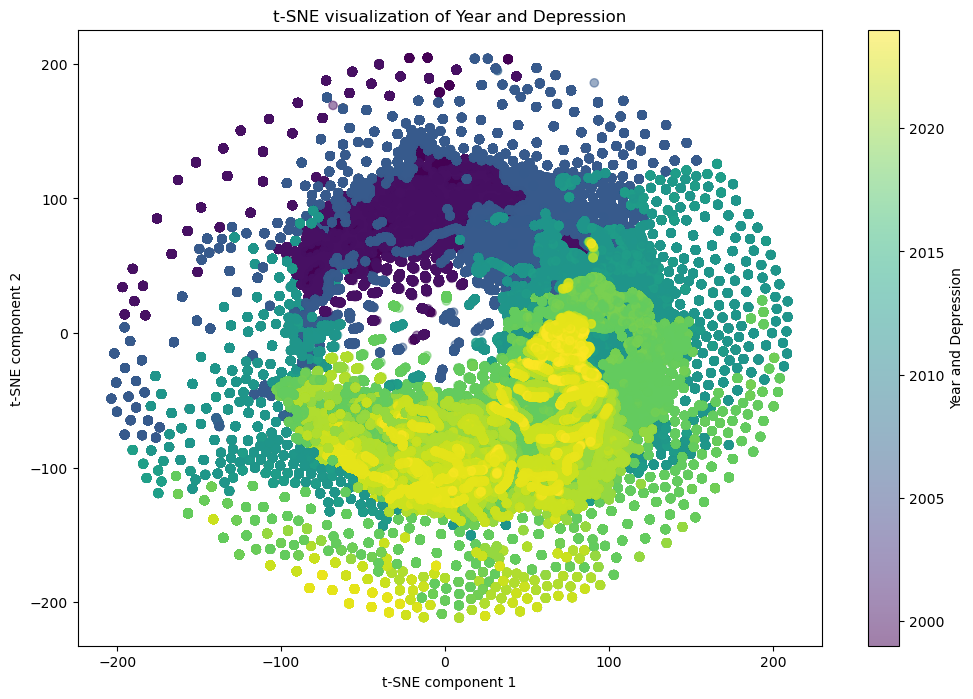

In [144]:
# Visualizar los resultados
year_dep = sub_df_encoded_2[['Año_ii','Depresion_ii_3', 'Depresion_ii_4']].sum(axis=1)
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, c=year_dep, cmap='viridis')  # Ejemplo: colorear por 'Depresion_ii'
plt.title('t-SNE visualization of Year and Depression')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(label='Year and Depression')
plt.show()